In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
path = Path('images/classes')
path.ls()

[PosixPath('images/classes/coral'), PosixPath('images/classes/king')]

In [5]:
for p in path.ls():
    verify_images(p, delete=True)

In [12]:
# Seed numpy's PNRG explicitly so that the exact same validation set is created each time
np.random.seed(42)
# Batch Size. Lower if you run out of memory
bs = 16
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
        ds_tfms=get_transforms(), size=299, num_workers=4, bs=bs).normalize(imagenet_stats)
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['coral', 'king'], 2, 341, 85)

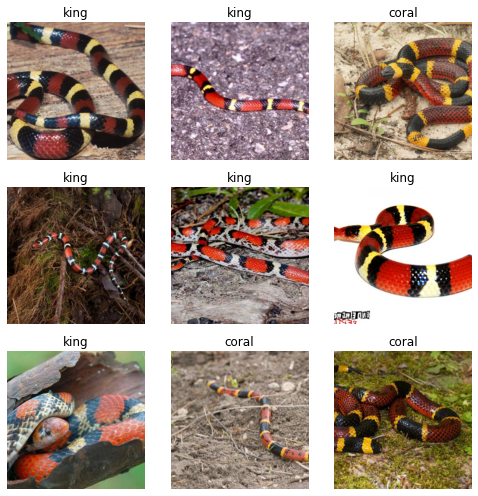

In [13]:
data.show_batch(rows=3, figsize=(7,7))

In [14]:
# Resnet 34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [85]:
# OR Resnet 50. Takes more memory so might need to reduce the batch size.
data.batch_size = bs // 2
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

RuntimeError: DataLoader worker (pid 12845) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

In [18]:
learn.save('stage-1')

In [27]:
doc(ClassificationInterpretation)

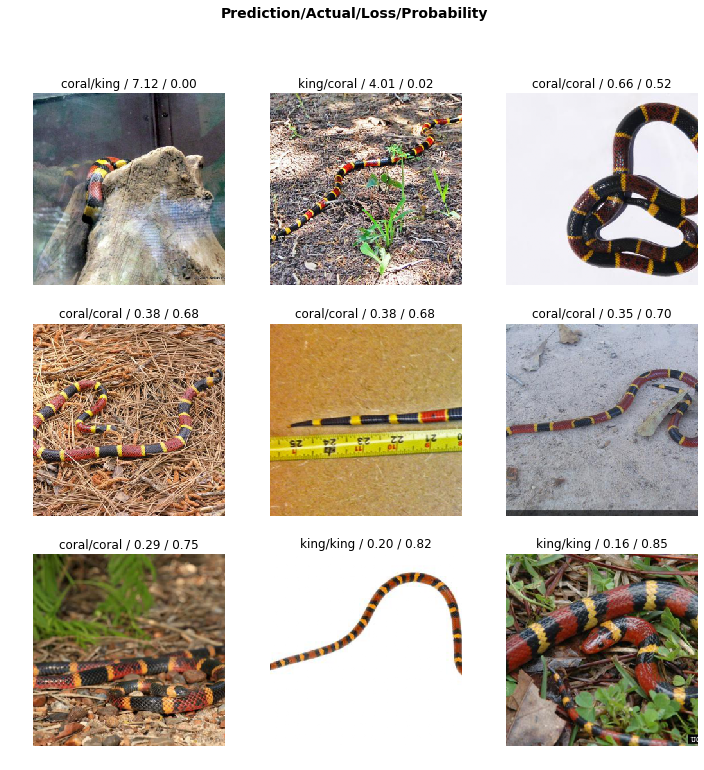

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


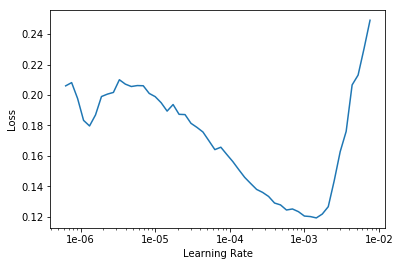

In [21]:
learn.lr_find()
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [71]:
# Probably will want to reload and try several combinations of max_lr range and number of epochs
learn.load('stage-1')
learn.unfreeze()

In [22]:
# Rule of thumb is go with 3e-4 for the 2nd number
# Pick the first number one the graph where the line trends down.
# 3e-5 is roughly halfway between 1e-5 and 1e-4 on a log scale graph
learn.fit_one_cycle(4, max_lr=slice(1e-4,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.178895,0.270337,0.082353,00:06
1,0.158308,0.287926,0.070588,00:05
2,0.144626,0.482193,0.058824,00:05
3,0.109421,0.387181,0.058824,00:05


In [23]:
learn.save('stage-2')

In [24]:
interp2 = ClassificationInterpretation.from_learner(learn)

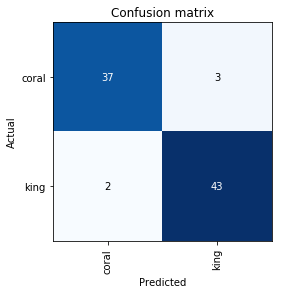

In [25]:
interp2.plot_confusion_matrix()

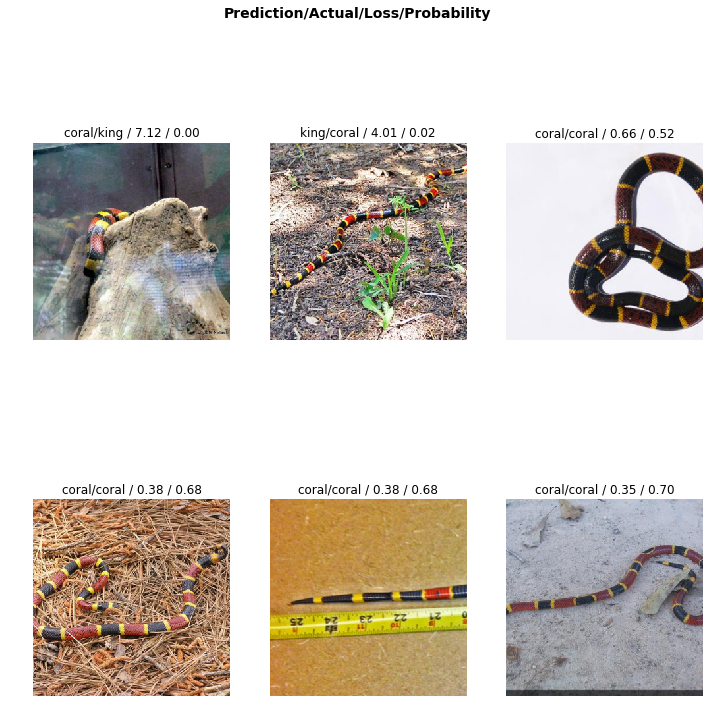

In [36]:
interp.plot_top_losses(6)